## PSF Nutrient Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

%matplotlib inline

In [2]:
PATH= '/results2/SalishSea/nowcast-green.201905/'
year=2012
start_date = dt.datetime(year,1,1)
end_date = dt.datetime(year,12,31)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}

df1=et.loadDFO(datelims=(start_date,end_date))
print(len(df1))
df1.head()

1647


,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,2012.0,4.0,6.0,13.683333,48.500333,-124.735167,2.1,None,None,None,0.97,mg/m^3,11.1,24.1,umol/L,30.228784,8.498574,2.08227,2012-04-06 13:41:00
1,2012.0,4.0,6.0,13.683333,48.500333,-124.735167,6.4,None,None,None,NaN,mg/m^3,12.0,24.7,umol/L,30.557292,8.331645,6.34591,2012-04-06 13:41:00
2,2012.0,4.0,6.0,13.683333,48.500333,-124.735167,11.3,None,None,None,1.08,mg/m^3,17.5,32.3,umol/L,30.600648,7.804145,11.2044,2012-04-06 13:41:00
3,2012.0,4.0,6.0,13.683333,48.500333,-124.735167,21.3,None,None,None,0.48,mg/m^3,20.7,37.0,umol/L,30.856334,7.659269,21.1192,2012-04-06 13:41:00
4,2012.0,4.0,6.0,13.683333,48.500333,-124.735167,31.6,None,None,None,NaN,mg/m^3,20.7,36.3,umol/L,31.085702,7.701101,31.331,2012-04-06 13:41:00


In [3]:
data=et.matchData(df1,filemap,fdict,start_date,end_date,'nowcast',PATH,1)

(Lat,Lon)= 51.67433333333334 -127.28216666666667  not matched to domain
(Lat,Lon)= 51.678333333333335 -127.332  not matched to domain


In [4]:
def rotmap(lon,lat,lon0,lat0,phi):
    # rotate around point (pick one near center of domain)
    # phi in degrees
    # first scale lats to match and center around lat0,lon0:
    lon1=(lon-lon0)*np.cos(lat0*np.pi/180)
    lat1=lat-lat0
    # now rotate:
    lon2=lon1*np.cos(phi*np.pi/180)-lat1*np.sin(phi*np.pi/180)
    lat2=lon1*np.sin(phi*np.pi/180)+lat1*np.cos(phi*np.pi/180)
    return lon2,lat2

In [5]:
cm1=cmocean.cm.thermal
#plt.get_cmap('PuBuGn')
#cm1=cmo.cm.matter
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])
blon,blat=rotmap(bathylon,bathylat,lon0,lat0,theta)

/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


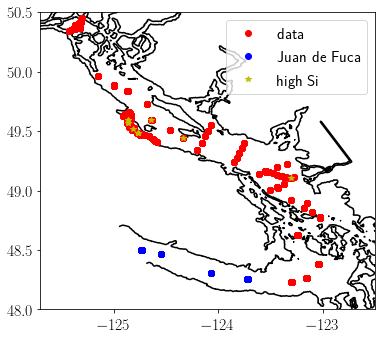

In [6]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
ax.plot(data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lon']], 
        data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lat']], 
        'bo', label = 'Juan de Fuca')

ax.plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

In [7]:
mod_chl_N=2.0
#mod_chl_N=1.6
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])
data['Chl']=data['Chlorophyll_Extracted']

# Nitrate

In [8]:
N_s, modmean_s, obsmean_s, bias_s, RMSE_s, WSS_s = et.stats(data.loc[data.Z<15,['N']],data.loc[data.Z<15,['mod_nitrate']])
N_i, modmean_i, obsmean_i, bias_i, RMSE_i, WSS_i = et.stats(data.loc[(data.Z>=15)&(data.Z<22),['N']],data.loc[(data.Z>=15)&(data.Z<22),['mod_nitrate']])
N_d, modmean_d, obsmean_d, bias_d, RMSE_d, WSS_d = et.stats(data.loc[data.Z>=22,['N']],data.loc[data.Z>=22,['mod_nitrate']])
N_d50, modmean_d50, obsmean_d50, bias_d50, RMSE_d50, WSS_d50 = et.stats(data.loc[data.Z>50,['N']],data.loc[data.Z>50,['mod_nitrate']])
N, modmean, obsmean, bias, RMSE, WSS = et.stats(data.loc[:,['N']],data.loc[:,['mod_nitrate']])
print('Nitrate')
print('z<15 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_s,bias_s,RMSE_s,WSS_s))
print('15 m<=z<22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_i,bias_i,RMSE_i,WSS_i))
print('z>=22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d,bias_d,RMSE_d,WSS_d))
print('z>50 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d50,bias_d50,RMSE_d50,WSS_d50))
print('all:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N,bias,RMSE,WSS))


Nitrate
z<15 m:
  N: 426
  bias: 0.5359361921712562
  RMSE: 5.352002324899694
  WSS: 0.9148945280297129
15 m<=z<22 m:
  N: 125
  bias: -0.46062244110107997
  RMSE: 3.128560317289873
  WSS: 0.8748016134278651
z>=22 m:
  N: 859
  bias: -0.6874751891468129
  RMSE: 2.252826395723791
  WSS: 0.8890398080389154
z>50 m:
  N: 618
  bias: -0.9012352428004213
  RMSE: 1.912489411288371
  WSS: 0.8696160378408475
all:
  N: 1410
  bias: -0.29773771258850346
  RMSE: 3.5515873693591193
  WSS: 0.9442942167091442


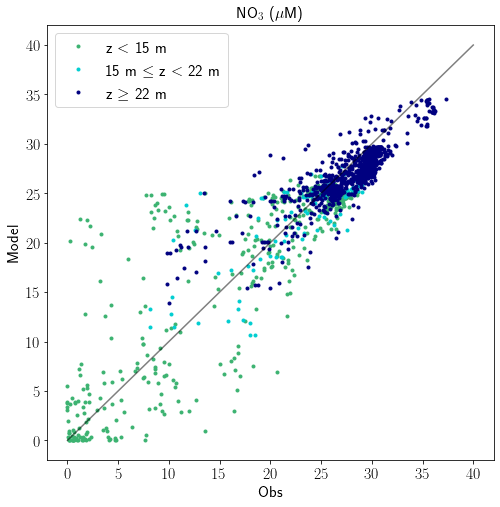

In [9]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'N','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')
ax.plot((0,40),(0,40),'k-',alpha=.5)

Nitrate, z<15
Jan-Mar:
  N: 63
  bias: -2.76103845626589
  RMSE: 2.8651084111044938
  WSS: 0.3594943004243707
April:
  N: 129
  bias: 4.775093752838842
  RMSE: 7.566351511103269
  WSS: 0.5484320646908952
May-Aug:
  N: 158
  bias: -1.288918893341024
  RMSE: 4.55890665871499
  WSS: 0.8899124637758185
Sep-Dec:
  N: 76
  bias: -0.13267984682399714
  RMSE: 3.65652762911241
  WSS: 0.9408332861092976


/home/eolson/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


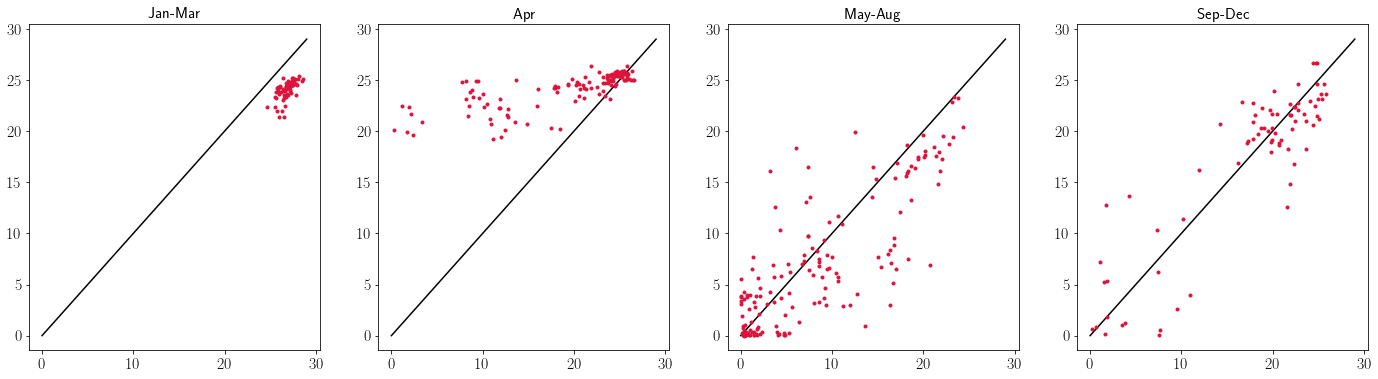

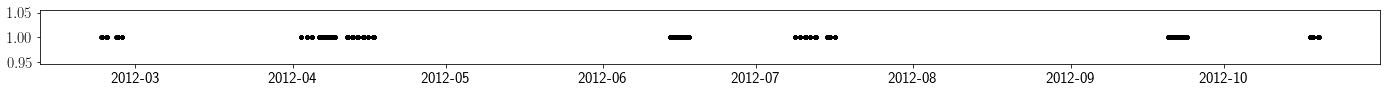

In [10]:
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,30),np.arange(0,30),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(year,4,1)),:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Jan-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[1].set_title('Apr')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Aug')
ii3=(data.Z < 15)&(data.dtUTC>dt.datetime(year,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Dec')

#ii4=(data.Z < 15)&(data.dtUTC<=dt.datetime(2016,4,1))&(data.dtUTC>dt.datetime(2016,2,1))
#ps=et.varvarPlot(ax[0],data.loc[ii4,:],obsvar,modvar,cols=('darkturquoise','navy'))
#ii5=(data.Z < 15)&(data.dtUTC<=dt.datetime(2016,5,1))&(data.dtUTC>dt.datetime(2016,4,1))
#ps=et.varvarPlot(ax[1],data.loc[ii5,:],obsvar,modvar,cols=('darkturquoise','navy'))

print('Nitrate, z<15')
print('Jan-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(year,4,1)),:],'N','mod_nitrate')
print('April:')
et.printstats(data.loc[ii1,:],'N','mod_nitrate')
print('May-Aug:')
et.printstats(data.loc[ii2,:],'N','mod_nitrate')
print('Sep-Dec:')
et.printstats(data.loc[ii3,:],'N','mod_nitrate')
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


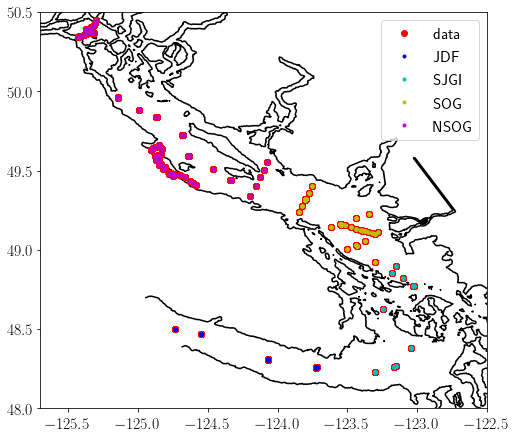

In [11]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax.plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax.plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax.plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax.plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

Text(0.5, 1.0, 'NO$_3$ ($\\mu$M)')

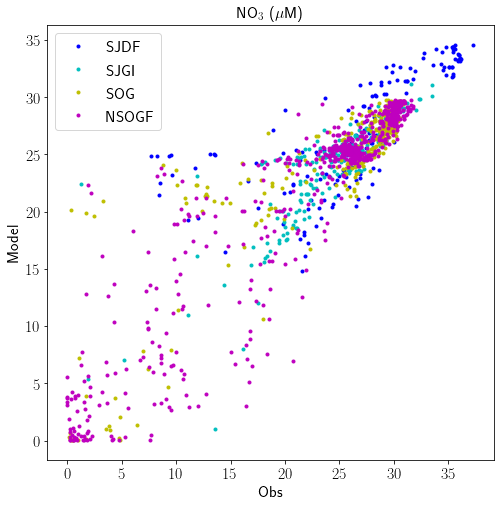

In [12]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,'N','mod_nitrate',cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,'N','mod_nitrate',cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,'N','mod_nitrate',cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,'N','mod_nitrate',cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')

(-40, 20)

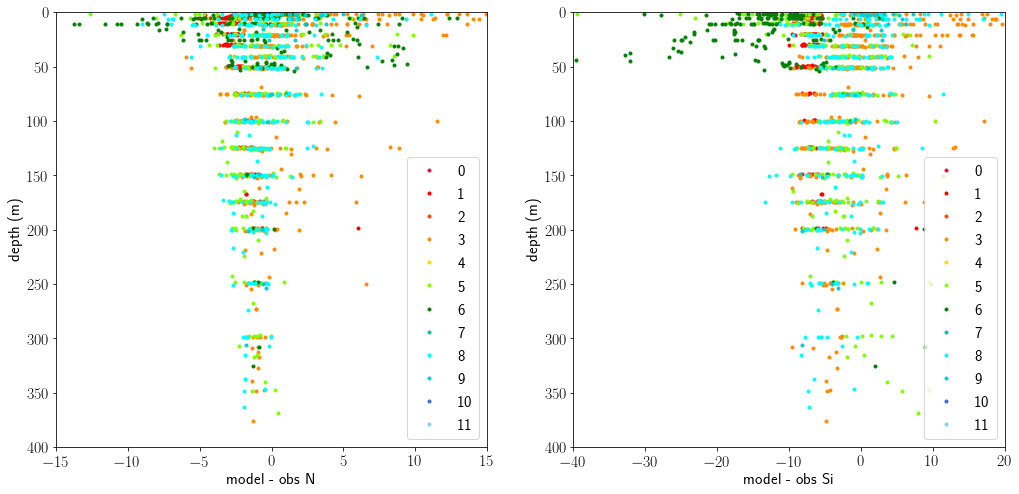

In [13]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan','darkturquoise','royalblue',
      'lightskyblue','blue','darkblue','mediumslateblue','blueviolet','darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['N']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model - obs N')
ax[1].set_xlabel('model - obs Si')
ax[0].set_xlim(-15,15)
ax[1].set_xlim(-40,20)

Text(0, 0.5, 'Nitrate Error')

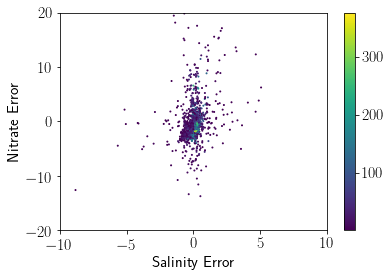

In [14]:
m=plt.scatter(data['mod_vosaline']-data['AbsSal'],data['mod_nitrate']-data['N'],c=data['Z'],s=1)
plt.colorbar(m)
plt.xlim(-10,10)
plt.ylim(-20,20)
plt.xlabel('Salinity Error')
plt.ylabel('Nitrate Error')

# dSi

In [15]:
print('dSi')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Si','mod_silicon')
print('15 m<=z<22 m:')
et.printstats(data.loc[(data.Z>=15)&(data.Z<22),:],'Si','mod_silicon')
print('z>=22 m:')
et.printstats(data.loc[data.Z>=22,:],'Si','mod_silicon')
print('all:')
et.printstats(data,'Si','mod_silicon')
print('obs Si < 50:')
et.printstats(data.loc[data.Si<50,:],'Si','mod_silicon')

dSi
z<15 m:
  N: 426
  bias: -1.4108945383572262
  RMSE: 13.199714304524008
  WSS: 0.7270322454677473
15 m<=z<22 m:
  N: 125
  bias: -3.1779924377441446
  RMSE: 7.848284668477949
  WSS: 0.7501847618256615
z>=22 m:
  N: 859
  bias: -3.613558954187816
  RMSE: 7.0461110261359465
  WSS: 0.7757754199457025
all:
  N: 1410
  bias: -2.909459056528746
  RMSE: 9.399329655738889
  WSS: 0.7917282748907013
obs Si < 50:
  N: 669
  bias: -0.19441712429170366
  RMSE: 10.716346462056423
  WSS: 0.6746280857742184


Text(0.5, 1.0, 'dSi ($\\mu$M)')

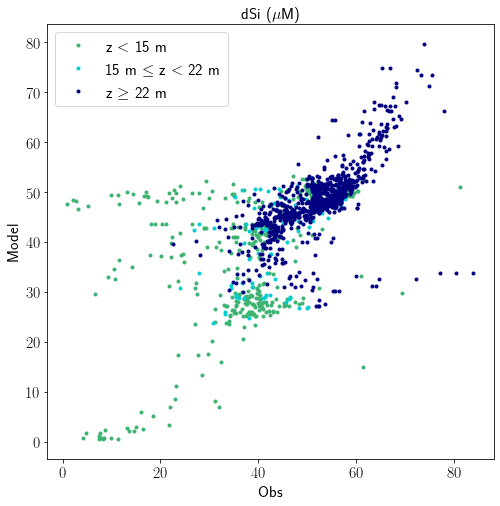

In [16]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'Si','mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('dSi ($\mu$M)')

Silicate, z<15
Feb-Mar:
  N: 63
  bias: -7.465781669011193
  RMSE: 7.577030673024226
  WSS: 0.17832746223243945
April:
  N: 129
  bias: 10.69766803711883
  RMSE: 17.185671624808897
  WSS: 0.5165230137445211
May-Jun:
  N: 158
  bias: -11.312085876698742
  RMSE: 13.063788311433875
  WSS: 0.7465267254722578
Sep-Oct:
  N: 76
  bias: 3.6396521518104876
  RMSE: 8.539090466017024
  WSS: 0.6878076979633466


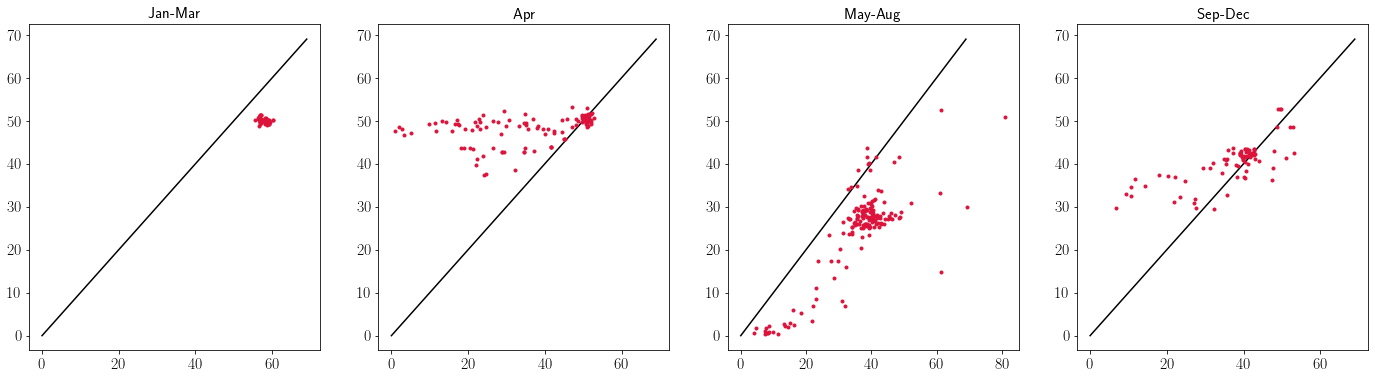

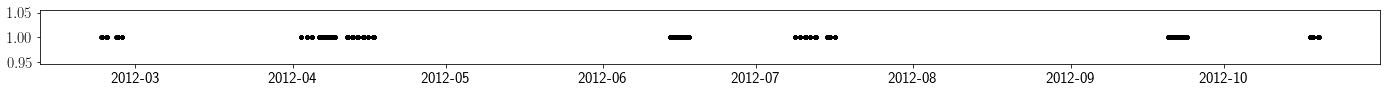

In [17]:
obsvar='Si'; modvar='mod_silicon'
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,70),np.arange(0,70),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(year,4,1)),:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Jan-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[1].set_title('Apr')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Aug')
ii3=(data.Z < 15)&(data.dtUTC>dt.datetime(year,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Dec')


print('Silicate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(year,4,1)),:],obsvar,modvar)
print('April:')
et.printstats(data.loc[ii1,:],obsvar,modvar)
print('May-Jun:')
et.printstats(data.loc[ii2,:],obsvar,modvar)
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],obsvar,modvar)
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

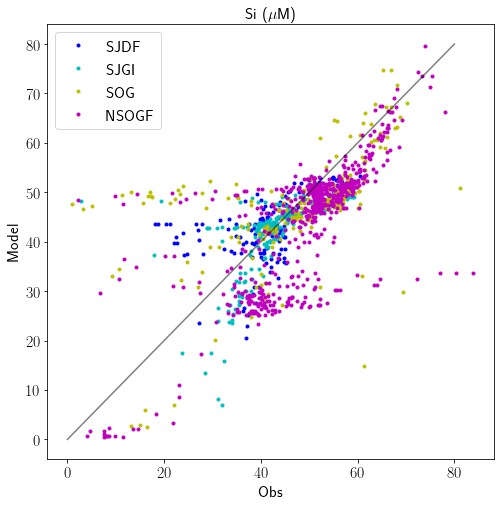

In [18]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('Si ($\mu$M)')
ax.plot((0,80),(0,80),'k-',alpha=.5)

# Ratios

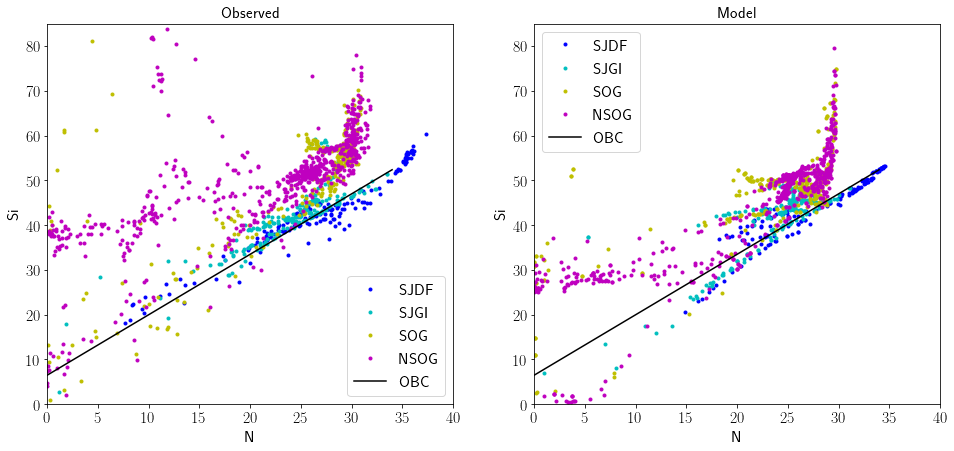

In [19]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0].plot(np.arange(0,35),1.35*np.arange(0,35)+6.46,'k-',label='OBC')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_nitrate'],dNSOG['mod_silicon'],'m.',label='NSOG')
ax[1].plot(np.arange(0,35),1.35*np.arange(0,35)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

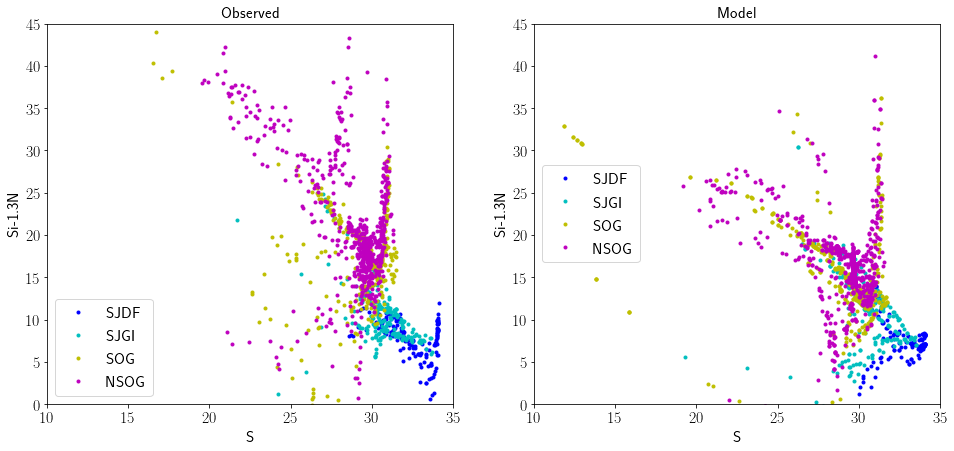

In [20]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['AbsSal'], dJDF['Si']-1.3*dJDF['N'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['AbsSal'],dSJGI['Si']-1.3*dSJGI['N'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['AbsSal'],dSOG['Si']-1.3*dSOG['N'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['AbsSal'],dNSOG['Si']-1.3*dNSOG['N'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('S')
ax[0].set_ylabel('Si-1.3N')
ax[0].set_xlim(10,35)
ax[0].set_ylim(0,45)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_vosaline'],dJDF['mod_silicon']-1.3*dJDF['mod_nitrate'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_vosaline'],dSJGI['mod_silicon']-1.3*dSJGI['mod_nitrate'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_vosaline'],dSOG['mod_silicon']-1.3*dSOG['mod_nitrate'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_vosaline'],dNSOG['mod_silicon']-1.3*dNSOG['mod_nitrate'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('S')
ax[1].set_ylabel('Si-1.3N')
ax[1].set_xlim(10,35)
ax[1].set_ylim(0,45)
ax[1].legend()

# Chlorophyll

In [21]:
print('log10[Chl+0.01]')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'l10_obsChl','l10_modChl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'l10_obsChl','l10_modChl')
print('all:')
et.printstats(data,'l10_obsChl','l10_modChl')
print('\n')
print('Chl')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Chlorophyll_Extracted','mod_Chl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'Chlorophyll_Extracted','mod_Chl')
print('all:')
et.printstats(data,'Chlorophyll_Extracted','mod_Chl')


log10[Chl+0.01]
z<15 m:
  N: 163
  bias: 0.019021593466243297
  RMSE: 0.508255561629019
  WSS: 0.5036130286796014
z>=15 m:
  N: 82
  bias: -0.06798875742459229
  RMSE: 0.40450551356465086
  WSS: 0.5605112371876291
all:
  N: 245
  bias: -0.010100238260485311
  RMSE: 0.47605518440796885
  WSS: 0.6017464804100694


Chl
z<15 m:
  N: 163
  bias: -0.927753169785019
  RMSE: 6.750394148766451
  WSS: 0.2013939515533174
z>=15 m:
  N: 82
  bias: -0.7144292507753368
  RMSE: 2.648129239144756
  WSS: 0.27636130261342307
all:
  N: 245
  bias: -0.8563549601572886
  RMSE: 5.715209605310309
  WSS: 0.22176390306472415


Text(0.5, 1.0, 'Chl ($\\mu$g/L)')

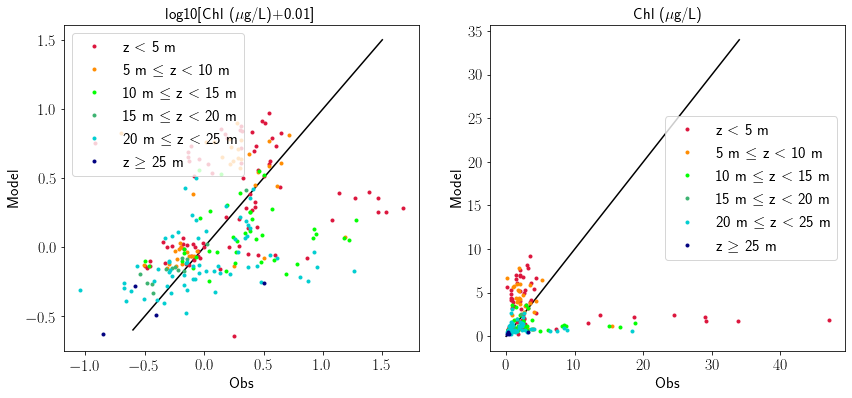

In [22]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01]')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chlorophyll_Extracted','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L)')